#  Reconstructing Granular Onset Age Distributions from Summary Statistics: A Rare Disease Use Case

by David Zhao  
Updated on July 2, 2025

## Introduction

In rare disease research, we often face a frustrating gap: while age of onset is a critical input for epidemiological models, health economics, and clinical trial design, individual-level data are rarely available. Instead, published studies typically report only summary statistics—a mean here, a median and interquartile range there—leaving modelers with incomplete foundations for age-specific analysis.

This limitation is more than a data inconvenience; it directly impacts the quality of disease burden estimation and market access models that guide resource allocation and patient care.

To address this challenge, we developed a simulation-based framework that reconstructs full onset age distributions from minimal inputs. By fitting plausible parametric distributions to reported quantiles, we can simulate granular age-at-onset profiles—including age-band–specific incidence proportions with uncertainty intervals.

This Python notebook demonstrates the approach using a real-world example: anti-GABABR encephalitis, a rare autoimmune encephalitis subtype. In this case, only quantile data were reported, and individual patient data were inaccessible. Yet through distribution modeling, we recreated actionable onset distributions for downstream use.

Our method draws inspiration from a technique introduced by Dr. Rick Wicklin in his SAS blog [post](https://blogs.sas.com/content/iml/2023/09/06/model-data-summary-stats.html?utm_source=chatgpt.com), where he showed how to fit parametric models to summary statistics using quantile-matching optimization. We’ve adapted and extended it for use in Python and applied it specifically to the context of rare disease epidemiology.

---

What You’ll Learn:  
	•	How to derive age-band–specific disease burden estimates from published quantile data  
	•	A step-by-step modeling workflow tailored to rare diseases  
	•	Reusable, lightweight code that can be customized for other indications  

---

Whether you’re preparing an HTA submission or estimating global incidence for an underdiagnosed condition, this method offers a scalable, transparent solution when raw data aren’t an option—but robust modeling still is.

## Workflow Overview

1. Select and fit candidate distributions: Fit the clinically plausible distributions: log-normal, weibull, generalized gamma, and metalog
2. Estimate parameters: Use quantile matching based on known median, q1, and q3 (simplified input scenario)
3. Evaluate goodness-of-fit: Calculate the sum of squared differences between modelled and observed quantiles. And identify the best-fitting distribution
4. Visual assessment: Plot modelled vs. empirical cdfs for the selected distribution
5. Estimate uncertainty: Generate 95% confidence intervals for age-band proportions using bootstrap resampling


## Import required library


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, weibull_min, gamma, genextreme # Importing necessary libraries for statistical distributions 
# from scipy.optimize import minimize # Optimization for parameter fitting
# from scipy.stats import probplot # Probability plot for visual assessment
# from sklearn.metrics import mean_squared_error # Mean Squared Error for goodness-of-fit
# from scipy.stats import gaussian_kde # Kernel Density Estimation for smooth CDF

## Input Data: Published summary statistics for AIE


Example input data is derived from a published observational study by Lamblin et al. (2024), which investigated autoimmune encephalitis patients in France and the Netherlands. The input includes the median, 25th and 75th percentiles (Q1 and Q3), minimum and maximum values, mean, and reported sample size.

The DOI of the publication: 10.1212/NXI.0000000000200229

The detailed values are as follows:


In [2]:
median = 66
q1 = 61 
q3 = 72
min = 19
max = 88
mean = 67
size = 111

In the following distribution simulation, I will use median, q1 and q3 to fit multiple candidate distributions, using quantile matching method to optimize parameters.

## Fitting select distributions


### Rational of parametric distributions selection

According to the literature on autoimmune encephalitis (AIE) onset age, the distribution is often significantly right-skewed, with a higher concentration of adult patients and fewer pediatric cases. In certain subtypes, the distribution also exhibits substantial kurtosis, deviating markedly from a normal distribution. These clinical patterns suggest that parametric distributions capable of accommodating both skewness and heavy tails are suitable candidates for simulating age distributions in real-world populations.

Including both classic distributions such as log-normal and Weibull, and more flexible ones like generalized gamma, helps capture a wide range of distribution shapes, accounting for variations in skewness and kurtosis—that is, the asymmetry and tail heaviness of the distribution.

### Fitting Log-normal distribution

Fit two parameters in log-normal distribution:
- mu: log-scale mean
- sigma: log-scale SD

#### Quantile matching with optimization

In [ ]:
import numpy as np
from scipy.stats import lognorm
from scipy.optimize import minimize # Optimization for parameter fitting

In [12]:
# Empirical quantiles
empirical_q = [q1, median, q3]

In [20]:
# Objective function: Minimize squared differences between model and empirical quantiles
def objective(params):
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    dist = lognorm(s=sigma, scale=np.exp(mu))
    theo_q = dist.ppf([0.25, 0.5, 0.75])
    return np.sum((np.array(theo_q) - empirical_q)**2)

This defines the objective function for optimization:

- Takes parameters mu and sigma as input
- Returns infinity if sigma is non-positive (constraint)
- Calculates theoretical quantiles using the log-normal distribution with given parameters
- Returns the sum of squared differences between theoretical and empirical quantiles (this is what we want to minimize)

In [21]:
# Initial guess for mu and sigma
initial_guess = [np.log(median), 0.5]
bounds = [(0, None), (0.01, 5)]

This sets up the optimization:

- `initial_guess`: Starting values for mu (log of median) and sigma (0.5)
- `bounds`: Constraints for the parameters - mu ≥ 0, sigma between 0.01 and 5

In [22]:
# Optimize
result = minimize(objective, x0=initial_guess, bounds=bounds)
mu_fit, sigma_fit = result.x

print(f'Fitted parameters:\n mu = {mu_fit:.3f}, sigma = {sigma_fit:.3f}')

Fitted parameters:
 mu = 4.192, sigma = 0.123


This performs the actual optimization:
- Uses scipy's `minimize` function to find the best-fitting parameters
- Extracts the fitted parameters from the result
- Prints the optimized mu and sigma values

The overall process implements **quantile matching** - a method where distribution parameters are estimated by minimizing the difference between theoretical quantiles (from the assumed distribution) and empirical quantiles (from the observed data). 

This is particularly useful when we only have summary statistics rather than the full dataset.

#### Simulate and visualize fitted distribution

In [24]:
import matplotlib.pyplot as plt

In [26]:
# Generate simulated onset ages
sim_ages = lognorm(s=sigma_fit, scale=np.exp(mu_fit)).rvs(10000)

The function `.rvs(10000)` generates 10,000 random variates (samples) from this fitted distribution. The result is stored in `sim_ages`, which contains 10,000 simulated onset ages

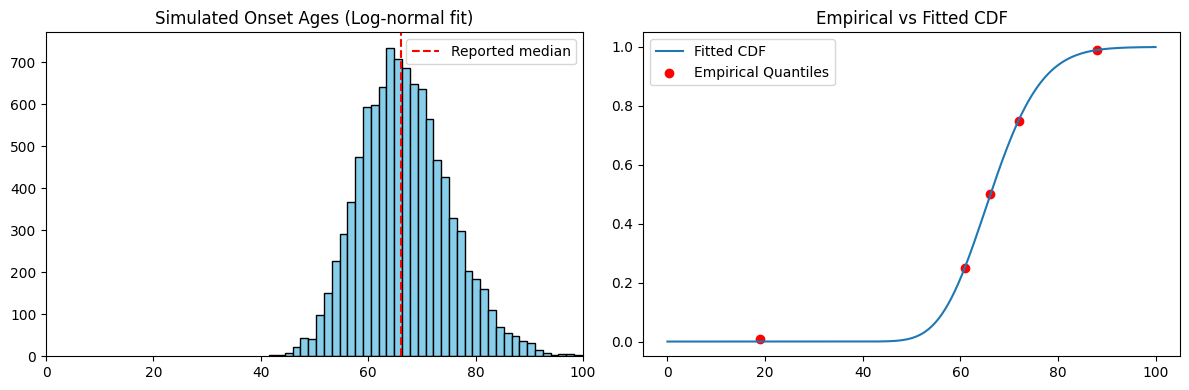

In [56]:
# Plot histogram + CDF overlay
fig, ax = plt.subplots(1,2, figsize=(12,4))

# Histogram
ax[0].hist(sim_ages, bins=50, color='skyblue', edgecolor='black')
ax[0].axvline(x=median, color='red', linestyle='--', label='Reported median')
ax[0].set_xlim(0, 100)  # Set x-axis range from 0 to 100
ax[0].set_title('Simulated Onset Ages (Log-normal fit)')
ax[0].legend()

# CDF comparison
x = np.linspace(0, 100, 300) # Age range for CDF from 0 to 100
model_cdf = lognorm(s=sigma_fit, scale=np.exp(mu_fit)).cdf(x) # Call cumulative distribution function on the distribution object
ax[1].plot(x, model_cdf, label='Fitted CDF')
ax[1].scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical Quantiles')
ax[1].set_title('Empirical vs Fitted CDF')
ax[1].legend()

plt.tight_layout()
plt.show()

## Fitting Weibull distribution

Fit 2-parameter Weibull distribution:
- c: Shape parameter 
- λ: Scale parameter

In [34]:
import numpy as np
from scipy.stats import weibull_min
from scipy.optimize import minimize

In [40]:
# Define quantile matching objective for Weibull
def weibull_objective(params):
    shape, scale = params
    if shape <= 0 or scale <= 0:
        return np.inf
    dist = weibull_min(c=shape, scale=scale)
    theo_q = dist.ppf([0.25, 0.5, 0.75])
    return np.sum((np.array(theo_q) - empirical_q) **2)

In [41]:
# Initial guess for shape and scale
initial_guess_weibull = [2, 10]
bounds_weibull = [(0.01, None), (0.01, None)]

result_weibull = minimize(weibull_objective, x0=initial_guess_weibull, bounds=bounds_weibull)
shape_fit_weibull, scale_fit_weibull = result_weibull.x

print(f"Fitted Weibull parameters:\n shape = {shape_fit_weibull:.3f}, scale = {scale_fit_weibull:.3f}")

Fitted Weibull parameters:
 shape = 9.460, scale = 69.247


**Setup and Optimization:**

- `initial_guess_weibull = [2, 10]`: Starting values for the optimization
  - Shape parameter (c) = 2
  - Scale parameter (λ) = 10
- `bounds_weibull = [(0.01, None), (0.01, None)]`: Parameter constraints
  - Both shape and scale must be ≥ 0.01 (positive values)
  - No upper bounds (None)

**Optimization Process:**

- `minimize(weibull_objective, x0=initial_guess_weibull, bounds=bounds_weibull)`: Uses scipy's minimize function to find the best-fitting Weibull parameters
- `weibull_objective`: The objective function defined in the previous cell that minimizes squared differences between theoretical and empirical quantiles
- `result_weibull.x`: Extracts the optimized parameters from the result

**Output:**

- `shape_fit_weibull`, `scale_fit_weibull`: The fitted shape and scale parameters

### Simulate and visualize fitted distribution

In [ ]:
import matplotlib.pyplot as plt

In [43]:
# Simulate from fitted Weibull
sim_ages_weibull = weibull_min(c=shape_fit_weibull, scale=scale_fit_weibull).rvs(10000)

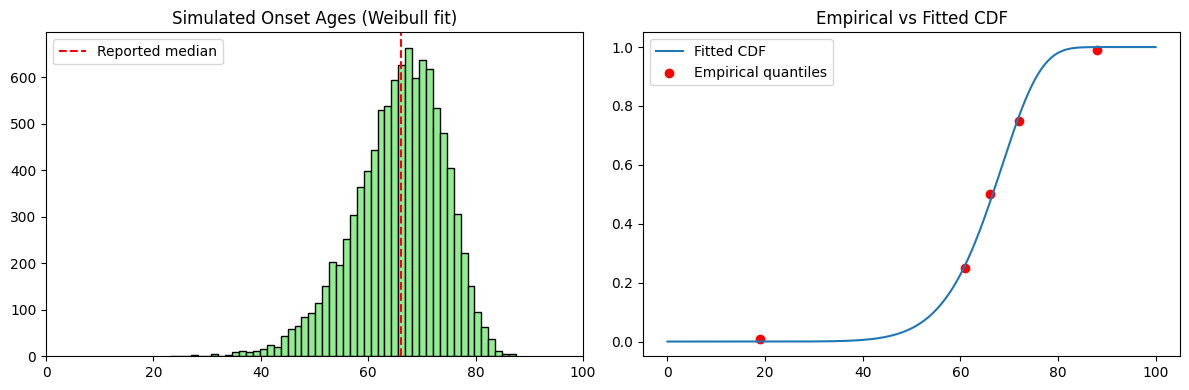

In [57]:
# Plot histogram
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].hist(sim_ages_weibull, bins=50, color='lightgreen', edgecolor='black')
ax[0].axvline(x=median, color='red', linestyle='--', label='Reported median')
ax[0].set_xlim(0, 100)
ax[0].set_title('Simulated Onset Ages (Weibull fit)')
ax[0].legend()

# Plot empirical vs fitted CDF
x_weibull = np.linspace(0, 100, 300)
model_cdf_weibull = weibull_min(c=shape_fit_weibull, scale=scale_fit_weibull).cdf(x_weibull)
ax[1].plot(x_weibull, model_cdf_weibull, label='Fitted CDF')
ax[1].scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical quantiles')
ax[1].set_title('Empirical vs Fitted CDF')
ax[1].legend()

plt.tight_layout()
plt.show()

## Fitting Generalized Gamma distribution

The generalized Gamma distribution has three parameters to fit:
- a: shape parameter
- c: power parameter
- scale: scale parameter

In [47]:
import numpy as np
from scipy.stats import gengamma
from scipy.optimize import minimize

In [48]:
# Define the quantile-matching objective function
def gengamma_objective(params):
    a, c, scale = params
    if a <= 0 or scale <= 0:
        return np.inf
    try:
        dist = gengamma(a=a, c=c, scale=scale)
        theo_q = dist.ppf([0.25, 0.5, 0.75])
        return np.sum((np.array(theo_q)- np.array(empirical_q))**2)
    except:
        return np.inf

In [50]:
# Run the optimization
initial_guess_gengamma = [2.0, 1.0, 10.0]
bounds_gengamma = [(0.01, None), (0.01, None), (0.01, None)]

result_gengamma = minimize(gengamma_objective, x0=initial_guess_gengamma, bounds=bounds_gengamma)
a_fit_gengamma, c_fit_gengamma, scale_fit_gengamma = result_gengamma.x

print(f"Fitted Generalized Gamma parameters:\n a = {a_fit_gengamma:.3f}, c = {c_fit_gengamma:.3f}, scale_fit_gengamma = {scale_fit_gengamma:.3f}")

Fitted Generalized Gamma parameters:
 a = 26.611, c = 1.583, scale_fit_gengamma = 8.409


/var/folders/b8/9ymtxc2j7rb00xx34s753cwc0000gn/T/ipykernel_81972/1451994867.py:9: RuntimeWarning: overflow encountered in square
  return np.sum((np.array(theo_q)- np.array(empirical_q))**2)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [ ]:
# Simulate and visualize
import matplotlib.pyplot as plt

In [52]:
# Simulate onset ages 
sim_ages_gengamma = gengamma(a = a_fit_gengamma, c = c_fit_gengamma, scale = scale_fit_gengamma).rvs(10000)

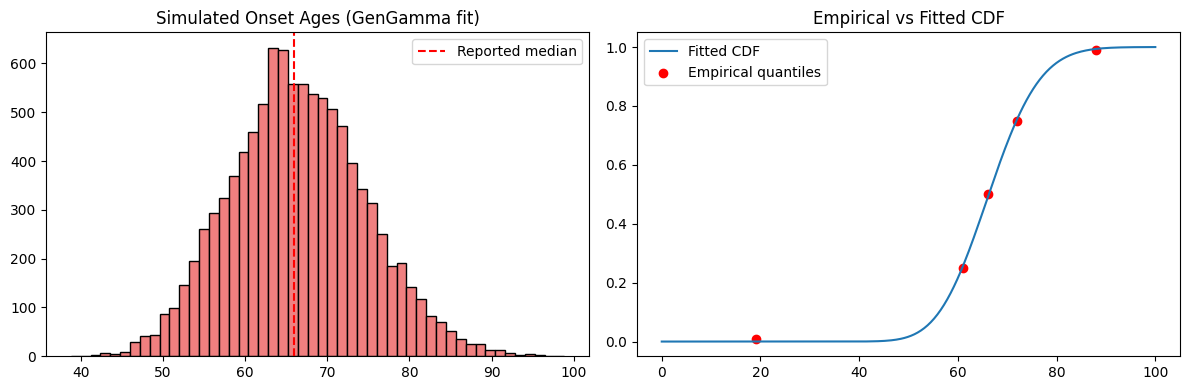

In [58]:
# Plot histogram and CDF
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

# Histogram
ax[0].hist(sim_ages_gengamma, bins=50, color='lightcoral', edgecolor='black')
ax[0].axvline(x=median, color='red', linestyle='--', label='Reported median')
ax[0].set_title('Simulated Onset Ages (GenGamma fit)')
ax[0].legend()

# CDF
x_gengamma = np.linspace(0, 100, 300)
model_cdf_gengamma = gengamma(a=a_fit_gengamma, c=c_fit_gengamma, scale=scale_fit_gengamma).cdf(x_gengamma)
ax[1].plot(x_gengamma, model_cdf_gengamma, label='Fitted CDF')
ax[1].scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical quantiles')
ax[1].set_title('Empirical vs Fitted CDF')
ax[1].legend()

plt.tight_layout()
plt.show()


## Evaluate goodness-of-fit

Calculate the sum of squared differences between modelled and observed quantiles. Identify the best-fitting distribution.

In [60]:
# Estimate quantiles from simulated age distributions
q25, q50, q75 = np.percentile(sim_ages, [25, 50, 75])

model_quantiles = np.array([q25, q50, q75])

# Calculate squared difference between modeled- and empirical quantiles
squared_diff = (model_quantiles - empirical_q) ** 2
sum_squared_diff = np.sum(squared_diff)
print(f"Sum of squared differences: {sum_squared_diff:.4f}")


Sum of squared differences: 0.0916


In [61]:
# Initialize dictionary for simulated age distributions
simulated_ages = {
    'lognormal': sim_ages,
    'weibull': sim_ages_weibull,
    'gengamma': sim_ages_gengamma
}

# Estimate quantiles for each distribution
quantiles = {}
for dist_name, ages in simulated_ages.items():
    q25, q50, q75 = np.percentile(ages, [25, 50, 75])
    quantiles[dist_name] = np.array([q25, q50, q75])
# Calculate squared differences between modelled and empirical quantiles
squared_diffs = {}
for dist_name, model_q in quantiles.items():
    squared_diff = (model_q - empirical_q) ** 2
    sum_squared_diff = np.sum(squared_diff)
    squared_diffs[dist_name] = sum_squared_diff
# Print the sum of squared differences for each distribution
for dist_name, sum_diff in squared_diffs.items():
    print(f"Sum of squared differences for {dist_name}: {sum_diff:.4f}")

Sum of squared differences for lognormal: 0.0916
Sum of squared differences for weibull: 0.5238
Sum of squared differences for gengamma: 0.0772


In this case, the Generalized Gamma distribution shows the smallest squared difference, indicating the best fit among the three candidate distributions.

## Estimate uncertainty

In this fictional example, the goal is to estimate the proportions of cases in three age subgroups: <12 years, 12–17 years, and ≥18 years. Using the bootstrap technique, we calculate the average proportion for each subgroup along with corresponding 95% confidence intervals.

In [63]:
# Define age bands
age_bands = [(0,12), (12, 18), (18, 100)]

# Bootstrap settings
n_iterations = 1000
n_samples = 10000 # per bootstrap iteration

In [65]:
# Bootstrap simulation
bootstrap_results_gengamma = []

for _ in range(n_iterations):
    sim_ages_gengamma2 = gengamma(a = a_fit_gengamma, c = c_fit_gengamma, scale = scale_fit_gengamma).rvs(n_samples)
    proportions = [np.mean((sim_ages_gengamma2 >= low) & (sim_ages_gengamma2 <= high)) for (low, high) in age_bands]
    bootstrap_results_gengamma.append(proportions)

bootstrap_array_gengamma = np.array(bootstrap_results_gengamma)    

In [68]:
print(bootstrap_array_gengamma[:7])

[[0.     0.     0.9999]
 [0.     0.     1.    ]
 [0.     0.     0.9999]
 [0.     0.     1.    ]
 [0.     0.     0.9999]
 [0.     0.     0.9998]
 [0.     0.     1.    ]]


In [70]:
# Summarize results
summary_gengamma = []
for i, band in enumerate(age_bands):
    props = bootstrap_array_gengamma[:, i]
    summary_gengamma.append({
        'Age Band': f'{band[0]}-{band[1]}',
        'Mean Proportion': round(np.mean(props), 4),
        '95% CI Lower': round(np.percentile(props, 2.5), 4),
        '95% CI Upper': round(np.percentile(props, 97.5), 4)
    })


df_summary_gengamma = pd.DataFrame(summary_gengamma)
print(df_summary_gengamma)

  Age Band  Mean Proportion  95% CI Lower  95% CI Upper
0     0-12           0.0000        0.0000           0.0
1    12-18           0.0000        0.0000           0.0
2   18-100           0.9999        0.9997           1.0


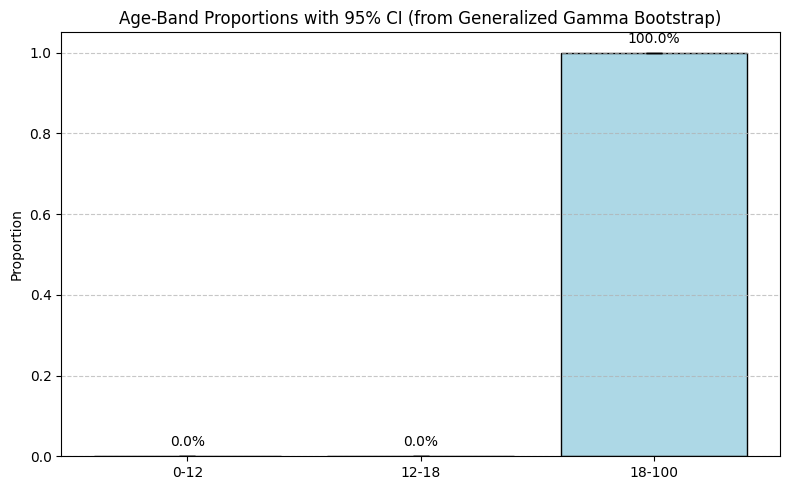

In [71]:
# Todo: Visualize mean proportion and 95% CI using a bar plot and error bars.
import matplotlib.pyplot as plt
import numpy as np

# Extract data from DataFrame
labels = df_summary_gengamma["Age Band"]
means = df_summary_gengamma["Mean Proportion"]
ci_lower = df_summary_gengamma["95% CI Lower"]
ci_upper = df_summary_gengamma["95% CI Upper"]

# Calculate error bars
error_lower = np.maximum(means - ci_lower, 0)
error_upper = np.maximum(ci_upper - means, 0)
error = [error_lower, error_upper]

# Create bar plot with error bars
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(labels, means, yerr=error, capsize=6, color='lightblue', edgecolor='black')

# Annotate percentages
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.annotate(f"{height:.1%}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom')

# Format the plot
ax.set_ylabel("Proportion")
ax.set_title("Age-Band Proportions with 95% CI (from Generalized Gamma Bootstrap)")
ax.set_ylim(0, 1.05 * ci_upper.max())
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Practical Guidance

This notebook provides a reusable template. When adapting to other diseases, ensure clinical plausibility of candidate distributions and interpret tail behavior carefully.